# Instalation of Spacy for english text preprocessing

*Note you might need to restart colab runtime after the installations of this cell due to some peculiar behaviour of Spacy 3.0

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download en

Connect to the google drive to access train data, test data and saved model of NLP competition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installation of indic nlp library for hindi text preprocessing 

In [ ]:

!git clone "https://github.com/anoopkunchukuttan/indic_nlp_library"
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
!pip install Morfessor
# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"/content/indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES="/content/indic_nlp_resources"

 Performing all the necessary and allowed imports

In [ ]:
import sys
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))
from indicnlp import common
common.set_resources_path(INDIC_NLP_RESOURCES)
from indicnlp import loader
loader.load()
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import math
import time
import torch.nn.functional as F

#Prepare Data for NMT

In [ ]:
def processhindi(text):

    text=text.replace('.','')
    text=text.replace(',','')
    text=text.replace('  ','')
    text=text.replace('-','')
    text=text.replace('(','')
    text=text.replace(')','')
    text=text.replace(':','')
    text=text.replace('"','')
    text=text.replace('!','')
    text=text.replace('?','')
    text=text.replace('/','')
    text=text.replace('~','')
    text=text.replace('[','')
    text=text.replace(']','')
    text=text.replace('।','')
    text=text.replace('|','')
    text=text.replace('♫','')
    
    return [t for t in indic_tokenize.trivial_tokenize(text)]
 

def processenglish(text):
    
    text=text.replace('.','')
    text=text.replace(',','')
    text=text.replace('  ','')
    text=text.replace('-','')
    text=text.replace('(','')
    text=text.replace(')','')
    text=text.replace(':','')
    text=text.replace('"','')
    text=text.replace('!','')
    text=text.replace('?','')
    text=text.replace('/','')
    text=text.replace('~','')
    text=text.replace('[','')
    text=text.replace('♫','')
    text=text.replace(']','')


    return [tok.text for tok in spacy_en.tokenizer(text)]
    

* Storing the train and test data set into dictionary, where hindi sentences are as the source('src') and english sentences are as target ('trg').

* followed by creation of  3 csv files as train.csv, test.csv and valid.csv which are train, test and validation data set respectively. 

In [ ]:

i=0
data={}
with open('/content/drive/MyDrive/train/train.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    for row in reader:
        if i==0:
            i+=1
            continue
        else:
            data[row[0]]={}
            data[row[0]]['src']=row[1]
            data[row[0]]['trg']=row[2]


with open('train.csv', 'w') as file:
     writer = csv.writer(file)
     writer.writerow(["hindi", "english"])
     for x in data:
         if int(x)<=100000 and len(data[x]['src'])<2000:
            writer.writerow([data[x]['src'],data[x]['trg']])

with open('val.csv', 'w') as file:
     writer = csv.writer(file)
     writer.writerow(["hindi", "english"])
     for x in data:
         if int(x)>100000 and len(data[x]['src'])<2000:
            writer.writerow([data[x]['src'],data[x]['trg']])



j=0
test_data={}
with open('/content/drive/MyDrive/train/testhindistatements.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    for row in reader:
        if j==0:
            j+=1
            continue
        else:
            test_data[row[0]]={}
            test_data[row[0]]['src']=row[2]
            test_data[row[0]]['trg']=data[row[1]]['trg']

with open('test.csv', 'w') as file:
     writer = csv.writer(file)
     writer.writerow(["hindi", "english"])
     for x in test_data:
         writer.writerow([test_data[x]['src'],test_data[x]['trg']])


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]
def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = Dataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/INDIC_NLP_HINDI')
from indic_nlp import *

SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Collect Statistics

Finding some statistical informations like average, maximum, minimum length of hindi and english sentences, number of unique tokens in hindi and english sentences, etc,  about the given training data and test data (test set for the final phase)

In [ ]:
def count_sentences(data):
    lengths=[0,50,100,150,200,250,300,350,400,450,500]
    hindi_count=[0]*10
    english_count=[0]*10

    for i in range(1,11):
        for x in data:
            if lengths[i-1]<len(data[x]['src'])<=lengths[i]:
                hindi_count[i-1]+=1
            if lengths[i-1]<len(data[x]['trg'])<=lengths[i]:
                english_count[i-1]+=1

    return hindi_count,english_count

In [ ]:
 hindi_count,english_count=count_sentences(test_data)

In [ ]:
print(hindi_count)
print(english_count)
print(len(data),sum(hindi_count))
print(len(data),sum(english_count))

[15832, 5263, 1858, 698, 280, 90, 47, 18, 7, 5]
[15717, 5135, 1973, 778, 307, 103, 43, 23, 10, 7]
102322 24098
102322 24096


In [ ]:

def max_min(data):
    max_hilen=0
    max_enlen=0
    min_hilen=3000
    min_enlen=3000
    for x in data:
        if len(data[x]['trg'])>max_enlen:
            max_enlen=len(data[x]['trg'])
        if len(data[x]['src'])>max_hilen:
            max_hilen=len(data[x]['src'])

        if len(data[x]['trg'])<min_enlen:
            min_enlen=len(data[x]['trg'])
        if len(data[x]['src'])<min_hilen:
            min_hilen=len(data[x]['src'])
    
    return max_hilen,max_enlen,min_hilen,min_enlen

In [ ]:
max_hilen,max_enlen,min_hilen,min_enlen=max_min(test_data)

In [ ]:
print(max_hilen,max_enlen)
print(min_hilen,min_enlen)

597 662
2 1


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline


X = [50,100,150,200,250,300,350,400,450,500]
hindi_count , english_count = count_sentences(data)

X_axis = np.arange(len(X))

plt.figure(figsize=(6,7))
plt.bar(X_axis - 0.2, hindi_count, 0.4, label = 'hindi',color = 'c',edgecolor = 'black')
plt.bar(X_axis + 0.2, english_count, 0.4, label = 'english',color = 'y',edgecolor = 'black')


plt.xticks(X_axis, X)
plt.xlabel("Lengths")
plt.ylabel("Number of sentences")
plt.title("Train Data")
plt.legend()


    
plt.show()




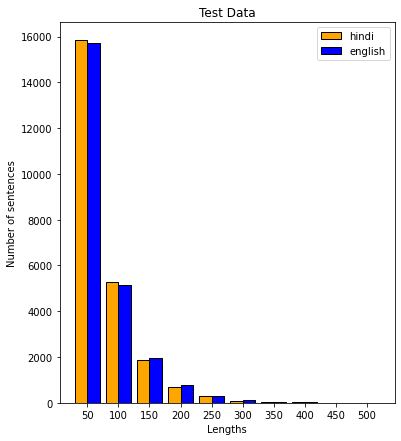

In [ ]:
hindi_count , english_count = count_sentences(test_data)



plt.figure(figsize=(6,7))
plt.bar(X_axis - 0.2, hindi_count, 0.4, label = 'hindi',color = 'orange',edgecolor = 'black')
plt.bar(X_axis + 0.2, english_count, 0.4, label = 'english',color = 'b',edgecolor = 'black')


plt.xticks(X_axis, X)
plt.xlabel("Lengths")
plt.ylabel("Number of sentences")
plt.title("Test Data")
plt.legend()


    
plt.show()

In [ ]:
def average_length(data):
    hindi_sum=0
    english_sum=0
    for x in data:
        hindi_sum+=len(data[x]['src'])
        english_sum+=len(data[x]['trg'])
    
    return hindi_sum/len(data), english_sum/len(data)



In [ ]:
print(average_length(test_data))

(51.36387021823915, 52.436395319890465)


In [ ]:
def noisy(data):
    same=[]
    for x in data:
        if data[x]['src']==data[x]['trg']:
            same.append(data[x]['src'])
    return same


In [ ]:
print(len(noisy(data)))

643


In [ ]:
max_len=0
source=''

for i in range(len(train_data.examples)):
    if len(train_data.examples[i].trg)>max_len:
        max_len=len(train_data.examples[i].trg)
        source=train_data.examples[i].trg

for i in range(len(valid_data.examples)):
    if len(valid_data.examples[i].trg)>max_len:
        max_len=len(valid_data.examples[i].trg)
        source=valid_data.examples[i].trg

print(max_len)
print(source)

298
['♫', 'my', 'oh', 'my', ',', 'walking', 'by', ',', 'who', '’s', 'the', 'apple', 'of', 'my', 'eye', '?', '♫', '♫', 'why', ',', 'it', "'s", 'my', 'very', 'own', 'clonie', '.', '♫', '♫', 'oh', ',', 'if', 'i', 'should', 'stroll', 'the', 'hood', ',', 'who', 'knew', 'i', 'could', 'look', 'so', 'good', '♫', '♫', 'just', 'talking', 'on', 'the', 'phone', 'to', 'clonie', '.', '♫', '♫', 'we', 'are', 'pals', ',', 'it', "'s", 'cool', ',', "'cause", 'we', "'re", 'not', 'lonely', ',', '♫', '♫', 'shallow', 'gene', 'pool', 'is', 'nothing', 'to', 'my', 'only', 'clonie', '.', '♫', '♫', 'me', 'and', 'you', ',', 'hustling', 'through', ',', 'holding', 'on', 'through', 'thick', 'and', 'thin', ',', '♫', '♫', 'just', 'day', 'by', 'day', ',', 'our', 'dna', ',', 'so', 'the', 'olson', 'twins', 'got', 'nothing', 'on', 'us', '.', '♫', '♫', 'we', "'ll", 'survive', ',', 'side', 'by', 'side', '.', 'mother', 'nature', ',', 'do', 'n’t', 'you', 'call', 'her', 'phony', ',', 'she', '’s', 'my', 'clonie', '.', '♫', '♫', 

# Transformer Architecture
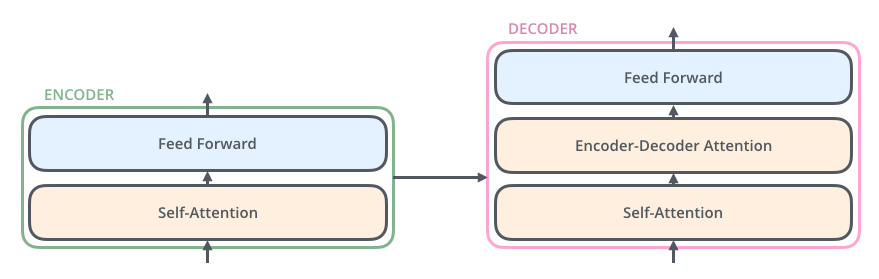

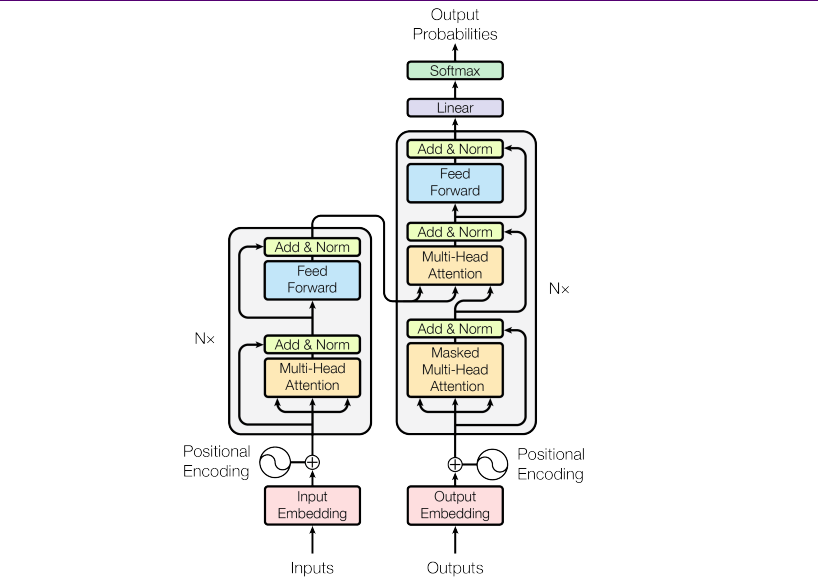

#**Encoder**
The Transformer's encoder doesn't compresses the whole source sentence, $X = (x_1, ... ,x_n)$, into one context vector, $z$. Instead it produces multiple context vectors, $Z = (z_1, ... , z_n)$. So, if our input sequence was 4 tokens long we would have $Z = (z_1, z_2, z_3, z_4)$.

First, the tokens are passed through a standard embedding layer. Next, because the model has no recurrent it has no idea about the order of the tokens within the sequence. This is taken care by  by employing a second embedding layer called a positional embedding layer.  This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence, starting with the first token, the $<sos>$ (start of sequence) token, in position 0.

Then the token and positional embeddings are elementwise summed together to produce a vector having information about both the token and  its position.

Beforehand the token embeddings are multiplied by  $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size. This reduces variance in the embeddings and the model is difficult to train reliably without this scaling factor. Dropout is then applied to the combined embeddings.

The combined embeddings are then passed through $3$ encoder layers to get $Z$, which will be used by the decoder.

**Encoder Layer:**

I first passed the Hindi sentence into the multi-head attention layer, applied a residual connection, and passed it through a Normalization layer. Followed by passing it to position-wise feedforward layer and then applied dropout, a residual connection and then layer normalization to get the output of this layer which was fed into the next layer. The multi-head attention layer is used by the encoder layer to attend the Hindi sentence, it applies attention over itself. What the normalization Layer does is that normalizes the values of the features, so that each feature has a mean of 0 and a standard deviation of 1. This allows Transformer, to be trained easier.

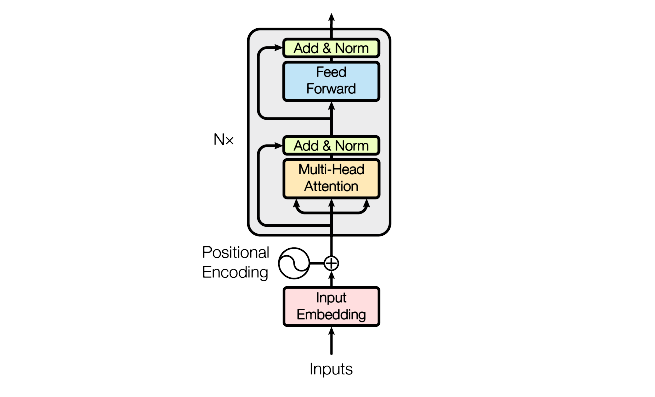

In [ ]:
class Encoder(nn.Module):
    def __init__(self, dimi, dimh, l, h, dimp, drop, device,  max_length = 300):
        super().__init__()

        
        self.embedding1 = nn.Embedding(dimi, 256)
        self.embedding2 = nn.Embedding(300, 256)
        self.device = device
        self.l = nn.ModuleList([EncoderLayer(256, h, dimp, 0.1, device) for _ in range(l)])
        self.drop = nn.Dropout(0.1)
        self.scale = torch.sqrt(torch.FloatTensor([256])).to(device)
        
    def forward(self, hindi, hindi_mask):
    
        
        hindi = self.drop((self.embedding1(hindi) * self.scale) + self.embedding2(torch.arange(0, hindi.shape[1]).unsqueeze(0).repeat(hindi.shape[0], 1).to(self.device)))
        for layer in self.l:
            hindi = layer(hindi, hindi_mask)
                
        return hindi

class EncoderLayer(nn.Module):
    def __init__(self, dimh, h, dimp, drop, device):
        super().__init__()
        
        self.positionwise_feedforward = PFF(256, dimp, 0.1)
        self.feed_norm = nn.LayerNorm(256)
        self.attention = MHA(256, h, 0.1, device)
        self.attention_norm = nn.LayerNorm(256)                                                                                                                       
        self.drop = nn.Dropout(0.1)
        
    def forward(self, hindi, hindi_mask):
        
        _hindi, _ = self.attention(hindi, hindi, hindi, hindi_mask)
        hindi = self.attention_norm(hindi + self.drop(_hindi))
        _hindi = self.positionwise_feedforward(hindi)
        hindi = self.feed_norm(hindi + self.drop(_hindi))
        
        return hindi

#**Mutli Head Attention Layer:**
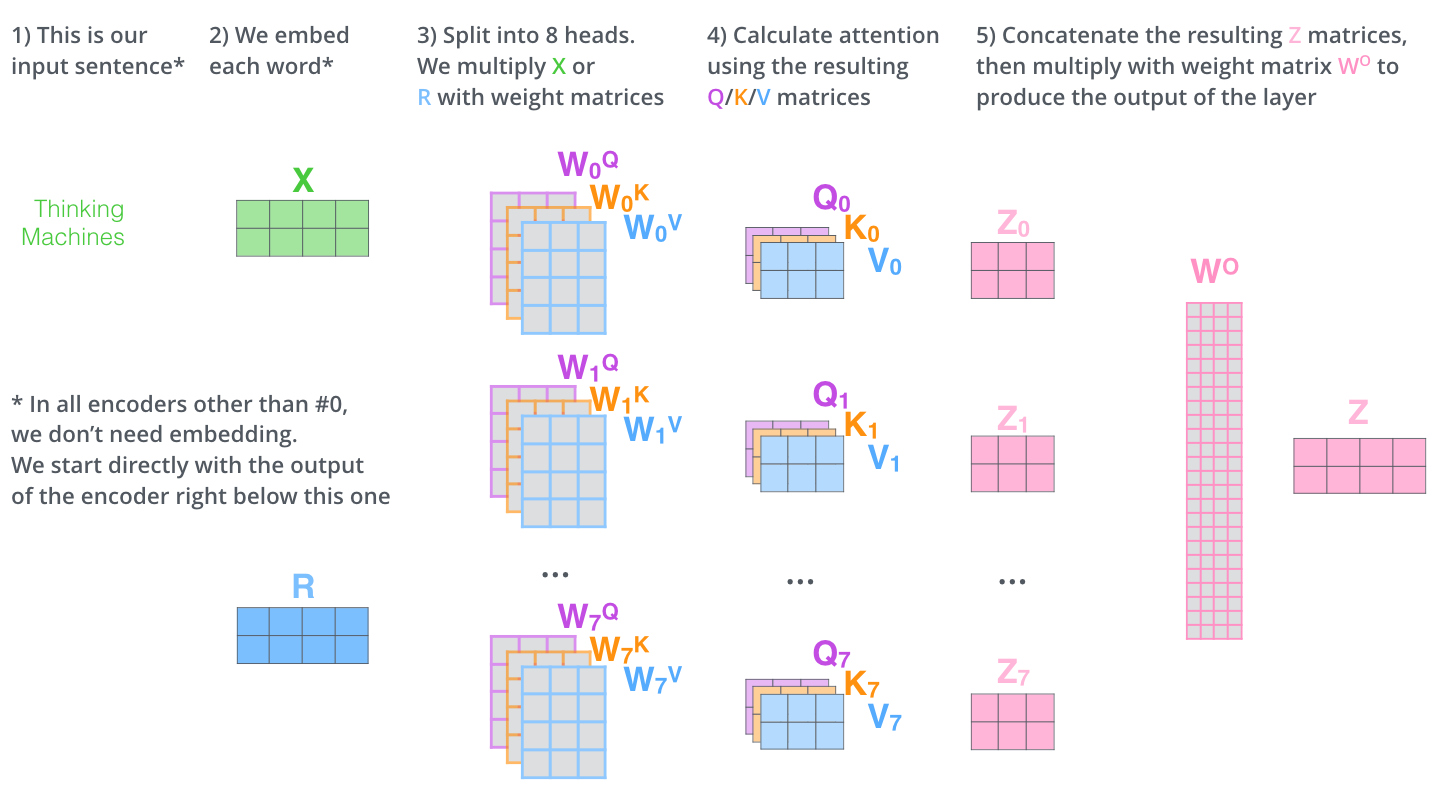


The Transformer uses scaled dot-product attention, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $d_k$ before, finally then multiplying by the value. $d_k$ is the head dimension

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$

q = the vector representing a word
The keys are the input word vectors for all the other tokens, and for the query token too,
V = your memory, thus all the words that have been generated before.

instead of paying attention to one concept per attention application, we pay attention to $h$. We then re-combine the heads into their hid\_dim shape, thus each hid\_dim is potentially paying attention to $h$ different concepts.
s.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$
$W^O$ is the linear layer applied at the end of the multi-head attention layer.


**Position wise Feedforward Layer:**
The other main block inside the encoder layer is the position-wise feedforward layer. This is relatively simple compared to the multi-head attention layer. The input is transformed from hid_dim to pf_dim, where pf_dim is usually a lot larger than hid_dim. The original Transformer used a hid_dim of 512 and a pf_dim of 2048. The ReLU activation function and dropout are applied before it is transformed back into a hid_dim representation.

* The feed-forward layer is weights that is trained during training and the exact same matrix is applied to each respective token position.

* Since it is applied without any communcation with or inference by other token positions it is a highly parallelizable part of the model.

* The role and purpose is to process the output from one attention layer in a way to better fit the input for the next attention layer.



In [ ]:
class MHA(nn.Module):
    def __init__(self, dimh, h, drop, device):
        super().__init__()
        
        self.v = nn.Linear(256, 256)
        self.o = nn.Linear(256, 256)
        self.drop = nn.Dropout(drop)
        self.k = nn.Linear(256, 256)
        self.dimh = 256
        self.h = h
        self.head_dim = 256 // h
        self.q = nn.Linear(256, 256)
        
    def forward(self, query, key, value, mask = None):
        
        Query = self.q(query)
        Query = Query.view(query.shape[0], -1, 8, self.head_dim).permute(0, 2, 1, 3)
        Key = self.k(key)
        Key = Key.view(query.shape[0], -1, 8, self.head_dim).permute(0, 2, 1, 3)
        Value = self.v(value)
        Value = Value.view(query.shape[0], -1, 8, self.head_dim).permute(0, 2, 1, 3)    
        out = torch.matmul(Query, Key.permute(0, 1, 3, 2)) / torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
        if mask is not None:
            out = out.masked_fill(mask == 0, -1e10)
        
        temp = torch.matmul(self.drop(torch.softmax(out, dim = -1)), Value) 
        temp = temp.permute(0, 2, 1, 3).contiguous()
        x = self.o(temp.view(query.shape[0], -1, 256))
        
        return x, torch.softmax(out, dim = -1)

class PFF(nn.Module):
    def __init__(self, dimh, dimp, drop):
        super().__init__()

        self.drop = nn.Dropout(drop)
        self.l1 = nn.Linear(256, dimp)
        self.l2 = nn.Linear(dimp, 256)
         
    def forward(self, x):
        
        return self.l2(self.drop(torch.relu(self.l1(x))))

#Decoding
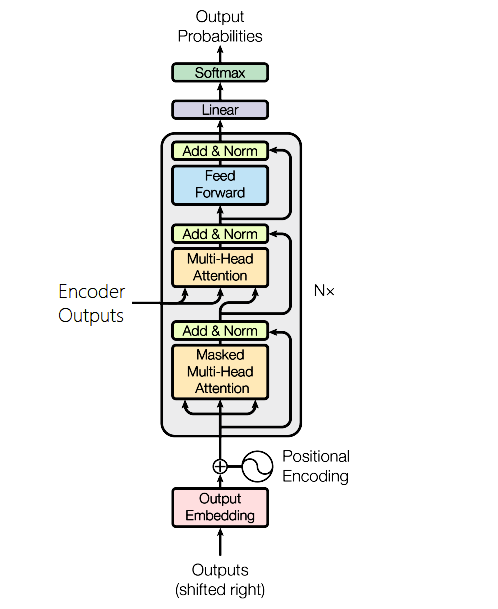

#**Decoder**
The objective of the decoder is to take the encoded representation of the source sentence, $Z$ , and convert it into predicted tokens in the target sentence, $\hat{Y}$ . We then compare $\hat{Y}$ with the actual tokens in the target sentence, Y , to calculate our loss, which will be used to calculate the gradients of our parameters and then use our optimizer to update our weights in order to improve our predictions. The decoder is similar to encoder, however it now has two multi-head attention layers. A masked multi-head attention layer over the target sequence, and a multi-head attention layer which uses the decoder representation as the query and the encoder representation as the key and value. The decoder uses positional embeddings and combines( via an elementwise sum) them with the scaled embedded target tokens, followed by dropout. The combined embeddings are then passed through the 3 decoder layers, along with the encoded source. The decoder representation after the $3^{th}$ layer is then passed through a linear layer.

**Docoder Layer:** 

the decoder layer is similar to the encoder layer except that it now has two multi-head attention layers, self_attention and encoder_attention.

The first performs self-attention, as in the encoder, by using the decoder representation so far as the query, key and value. This is followed by dropout, residual connection and layer normalization. This self_attention layer uses the target sequence mask, trg_mask, so as to stop the decoder from "cheating" by listening to tokens that are "ahead" of the one it is currently processing because it processes all tokens within the target sentence in parallel.

The second is how we actually feed the encoded source sentence, enc_src, into our decoder. In this multi-head attention layer the queries are the decoder representations and therefore the keys and values are the encoder representations. Here, the source mask, src_mask is employed to stop the multi-head attention layer from getting to tokens within the source sentence. This is then followed by the dropout, residual connection and layer normalization layers.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, dimo, dimh, l, h, dimp, drop, device, max_length = 300):
        super().__init__()
        
        self.embedding1 = nn.Embedding(dimo, 256)
        self.embedding2 = nn.Embedding(max_length, 256)
        self.device = device
        
        self.layers = nn.ModuleList([DecoderLayer(256, h, 512, 0.1, device) for _ in range(l)])
        
        self.fc_out = nn.Linear(256, dimo)
        
        self.drop = nn.Dropout(0.1)
        
    def forward(self, english, enc_src, english_mask, src_mask):
        
        pos = torch.arange(0, english.shape[1]).unsqueeze(0).repeat(english.shape[0], 1).to(self.device)   
        english = self.drop((self.embedding1(english) * torch.sqrt(torch.FloatTensor([256])).to(device)) + self.embedding2(pos))
        
        for layer in self.layers:
            english, attention = layer(english, enc_src, english_mask, src_mask)
        
            
        return self.fc_out(english), attention

class DecoderLayer(nn.Module):
    def __init__(self, dimh, h, dimp, drop, device):
        super().__init__()
        

        self.drop = nn.Dropout(0.1)
        self.self_attn_layer_norm = nn.LayerNorm(256)
        self.enc_attn_layer_norm = nn.LayerNorm(256)
        self.ff_layer_norm = nn.LayerNorm(256)
        self.self_attention = MHA(dimh, h, 0.1, device)
        self.encoder_attention = MHA(dimh, h, 0.1, device)
        self.positionwise_feedforward = PFF(256, 512, 0.1)
                                                                     
                                                                
    def forward(self, english, enc_src, english_mask, src_mask):
    
        _english, _ = self.self_attention(english, english, english, english_mask)
        english = self.self_attn_layer_norm(english + self.drop(_english))
        _english, attention = self.encoder_attention(english, enc_src, enc_src, src_mask)
        english = self.enc_attn_layer_norm(english + self.drop(_english))
        _english = self.positionwise_feedforward(english)
        english = self.ff_layer_norm(english + self.drop(_english))
        
        return english, attention

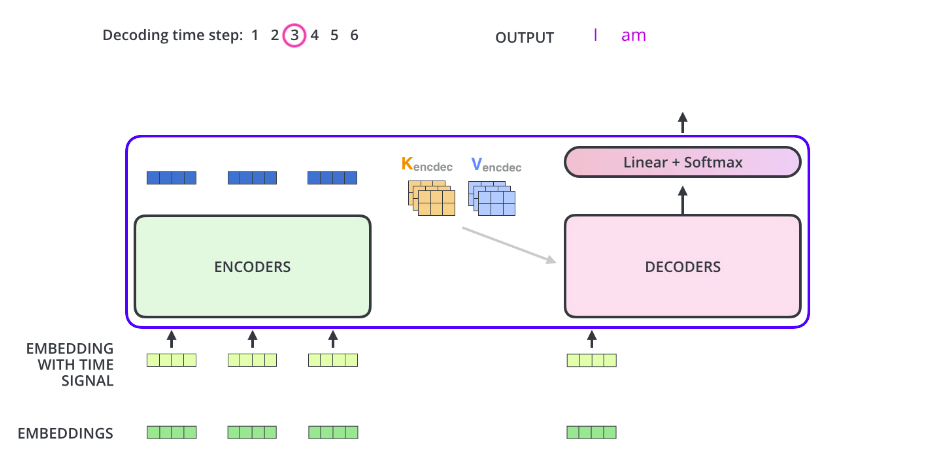

#**Sequence to sequence**
Finally, we have the Seq2Seq module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a $<pad>$ token. It is 1 where the token is not a $<pad>$ token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the energy, which of shape $[batch size, n heads, seq len, seq len]$.

The target mask is slightly more complicated. First, we create a mask for the $<pad>$ tokens, as we did for the source mask. Next, we create a "subsequent" mask, trg_sub_mask, using torch.tril. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones

In [ ]:

class Seq2Seq(nn.Module):
    def __init__(self, enc, dec, spi, tpi, device):
        super().__init__()
        
        self.enc = enc
        self.dec = dec
        self.spi = spi
        self.tpi = tpi
        self.device = device
        
    def make_hindi_mask(self, hindi):
    
        return (hindi != self.spi).unsqueeze(1).unsqueeze(2)
    
    def make_english_mask(self, english):
        
        english_pad_mask = (english != self.tpi).unsqueeze(1).unsqueeze(2)        
        english_sub_mask = torch.tril(torch.ones((english.shape[1], english.shape[1]), device = self.device)).bool() 
    
        return english_pad_mask & english_sub_mask

    def forward(self, hindi, english):
        
        enc_hindi = self.enc(hindi,self.make_hindi_mask(hindi))
        output, attention = self.dec(english, enc_hindi, self.make_english_mask(english), self.make_hindi_mask(hindi))
         
        return output, attention




#Initialising the encoder and decoders.
The paper does not mention which weight initialization scheme was used, however Xavier uniform is quite common amongst Transformer models, so we I used it here.The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so I will implemented that.  Learning rate needs to be lower than the default used by Adam or else I found learning to unstable unstable.

In [ ]:

enc = Encoder(len(SRC.vocab), 256, 3, 8, 512, 0.1, device)

dec = Decoder(len(TRG.vocab), 256, 3, 8, 512, 0.1, device)


model = Seq2Seq(enc, dec, SRC.vocab.stoi[SRC.pad_token], TRG.vocab.stoi[TRG.pad_token], device).to(device)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG.vocab.stoi[TRG.pad_token])

#**Traing the Model**
As we want our model to predict the <eos> token but not have it be an input into our model we simply slice the <eos> token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg}  = [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} = [sos, x_1, x_2, x_3]
\end{align*}$$
$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the $<eos>$ token:

$$\begin{align*}
\text{output} = [y_1, y_2, y_3, eos]
\end{align*}$$
$y_i$ denotes predicted target sequence element. We then calculate our loss using the original trg tensor with the $<sos>$ token sliced off the front, leaving the $<eos>$ token:

$$\begin{align*}
\text{output} = [y_1, y_2, y_3, eos]\\
\text{trg[1:]} = [x_1, x_2, x_3, eos]
\end{align*}$$
We then calculate our losses and update our parameters as is standard.

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [ ]:
def train(model, set, optimizer, criterion, clip):
    
    epoch_loss = 0
    model.train()

    for point , batch in enumerate(set):
        
        hindi = batch.src
        english = batch.trg
        optimizer.zero_grad()
        output, _ = model(hindi, english[:,:-1])        
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        english = english[:,1:].contiguous().view(-1)
        loss = criterion(output, english)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(set)

def evaluate(model, set, criterion):
    
    epoch_loss = 0
    model.eval()
    
    with torch.no_grad():
    
        for point , batch in enumerate(set):
            hindi = batch.src
            english = batch.trg
            output, _ = model(hindi, english[:,:-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            english = english[:,1:].contiguous().view(-1)
            loss = criterion(output, english)
            epoch_loss += loss.item()
        
    return epoch_loss / len(set)





#Start training
the model and evalution for the same on the basis of training and validation loss as the number of epochs.

**Note:** You can skip running cells(next 4 cells) under this section, if you just want to reproduce the result using the saved model parameters given in the google form("Transformer.pt")

In [ ]:
def epoch_time(start, end):
    total = end - start
    mins = int(total / 60)
    secs = int(total - (mins * 60))
    return mins, secs



training_loss=[]
validation_loss=[]

best_valid_loss = float('inf')

for epoch in range(20):
    
    start = time.time()
    
    train_loss = train(model, train_iterator, torch.optim.Adam(model.parameters(), lr = LEARNING_RATE) , nn.CrossEntropyLoss(ignore_index = TRG.vocab.stoi[TRG.pad_token]), 1)
    training_loss.append(train_loss)
    valid_loss = evaluate(model, valid_iterator,nn.CrossEntropyLoss(ignore_index = TRG.vocab.stoi[TRG.pad_token]))
    validation_loss.append(valid_loss)
    
    end = time.time()
    
    mins, secs = epoch_time(start, end)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Transformer.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {mins}m {secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')
    print("=========================================================================")

Epoch: 01 | Time: 2m 43s
	Train Loss: 4.281
	 Val. Loss: 3.517
Epoch: 02 | Time: 2m 42s
	Train Loss: 3.393
	 Val. Loss: 3.075
Epoch: 03 | Time: 2m 43s
	Train Loss: 3.000
	 Val. Loss: 2.862
Epoch: 04 | Time: 2m 43s
	Train Loss: 2.758
	 Val. Loss: 2.739
Epoch: 05 | Time: 2m 44s
	Train Loss: 2.583
	 Val. Loss: 2.657
Epoch: 06 | Time: 2m 45s
	Train Loss: 2.451
	 Val. Loss: 2.616
Epoch: 07 | Time: 2m 46s
	Train Loss: 2.351
	 Val. Loss: 2.588
Epoch: 08 | Time: 2m 44s
	Train Loss: 2.268
	 Val. Loss: 2.555
Epoch: 09 | Time: 2m 43s
	Train Loss: 2.197
	 Val. Loss: 2.538
Epoch: 10 | Time: 2m 42s
	Train Loss: 2.136
	 Val. Loss: 2.546
Epoch: 11 | Time: 2m 42s
	Train Loss: 2.083
	 Val. Loss: 2.512
Epoch: 12 | Time: 2m 42s
	Train Loss: 2.036
	 Val. Loss: 2.513
Epoch: 13 | Time: 2m 41s
	Train Loss: 1.991
	 Val. Loss: 2.503
Epoch: 14 | Time: 2m 40s
	Train Loss: 1.952
	 Val. Loss: 2.502
Epoch: 15 | Time: 2m 41s
	Train Loss: 1.914
	 Val. Loss: 2.503
Epoch: 16 | Time: 2m 40s
	Train Loss: 1.883
	 Val. Loss

In [ ]:
print(training_loss)
print(validation_loss)

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 


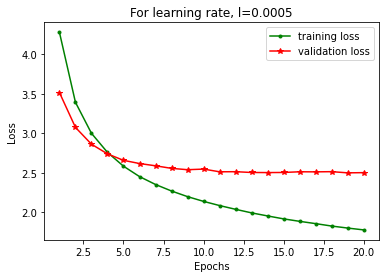

In [ ]:
x = np.linspace(1, 20, 20)
  
plt.plot(x, training_loss,color='g',marker='.', label='training loss')
plt.plot(x, validation_loss,color='r',marker='*',label='validation loss')
plt.title("For learning rate, l="+str(LEARNING_RATE))
  
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
  
plt.show()

#Tanslate and Visualise attention
Now we can can translations from our model with the translate_sentence function below.

The steps taken are:


* numericalize the source sentence
convert it to a tensor and add a batch dimension
* create the source sentence mask
* feed the source sentence and mask into the encoder
* create a list to hold the output  sentence initialized with an $<sos>$ token
while we have not hit a maximum length
* convert the current output sentence prediction into a tensor with a batch dimension
* create a target sentence mask
place the current output, encoder output and both masks into the decoder
* get next output token prediction from decoder along with attention
* add prediction to current output sentence prediction
* break if the prediction was an $<eos>$ token
convert the output sentence from indexes to tokens
return the output sentence (with the $<sos>$ token removed) and the attention from the last layer.

Load the model "Transformer.pt" from the drive to reproduce the result submitted on codalab

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Transformer.pt'))

<All keys matched successfully>

Produces the english translations of hindi sentence given.

**Note:** I have produced english translations of maximum size $120$ only.

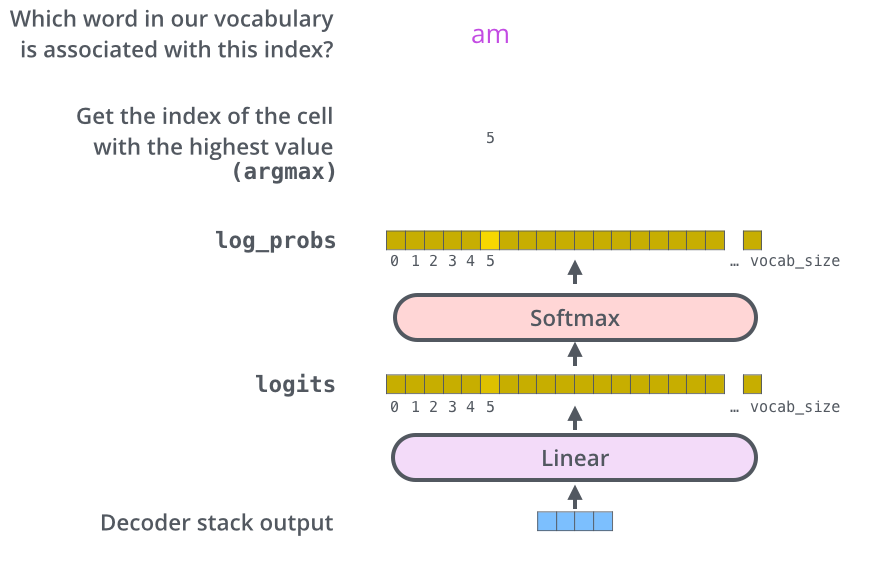

In [ ]:
def GetTranslation(sentence, sf, tf, model, device, len = 120):
    
    model.eval()
        
    tokens = sentence
    tokens = [sf.init_token] + tokens + [sf.eos_token]    
    index = [sf.vocab.stoi[token] for token in tokens]
    src_mask = model.make_hindi_mask(torch.LongTensor(index).unsqueeze(0).to(device))
    
    with torch.no_grad():
        enc_src = model.enc(torch.LongTensor(index).unsqueeze(0).to(device), src_mask)

    tindex = [tf.vocab.stoi[tf.init_token]]

    for i in range(120):

        trg_tensor = torch.LongTensor(tindex).unsqueeze(0).to(device)
        trg_mask = model.make_english_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.dec(trg_tensor, enc_src, trg_mask, src_mask)
        
        prediction = output.argmax(2)[:,-1].item()
        tindex.append(prediction)

        if prediction == tf.vocab.stoi[tf.eos_token]:
            break
    
    
    return  [tf.vocab.itos[i] for i in tindex][1:], attention



In [ ]:
example_idx = 90

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
#print(f'trg = {trg}')
translation, attention = GetTranslation(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['(', 'हंसी', ')', 'और', 'मैं', 'खास', 'तौर', 'पे', 'टी', '.', 'एस', '.', 'ए', '.', 'से', '।', 'क्यूंकि', 'मुझे', 'हर', 'बार', 'व्यक्तिगत', 'चेक', 'का', 'अनुभव', 'करना', 'पढता', 'है', '।']
predicted trg = ['(', 'laughter', ')', 'and', 'i', "'ve", 'been', 'able', 'to', 'actually', 'launch', 'a', 'special', 'investigation', '--', 'because', 'i', 'have', 'to', 'experience', 'every', 'single', 'time', 'i', 'have', 'to', 'experience', '.', '<eos>']


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [ ]:
def Attention(sentence, translation, attention):
    
    
    fig = plt.figure(figsize=(10,15))

    mpl.rcParams['font.sans-serif'] = ['Source Han Sans TW',
                                   'sans-serif',
                                   'Arial Unicode MS'  
                                   ]
    for i in range(8):
        
        ax = fig.add_subplot(4, 2, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='hot') 
        ax.tick_params(labelsize=12)
        
        ax.set_xticklabels(['']+['<sos>']+[t for t in sentence]+['<eos>'], 
                           rotation=45)
        
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Attention(src, translation, attention)

#Creating answer.txt
Saving the 24102 translations in english of the given hindi sentences in the test data.

In [ ]:
m=1
file1 = open("answer.txt","w")
for example_idx in range(24102):
    src = vars(test_data.examples[example_idx])['src']
    translation, attention = GetTranslation(src, SRC, TRG, model, device)
    translation=translation[:-1]
    trans=''
    for i in range(len(translation)):
        if translation[i]=='na' or translation[i]=="n't" or translation[i][0]=="'" or translation[i][0]=="," or translation[i][0]=="?" or translation[i][0]=="." or translation[i][0]=="!":
            trans=trans+translation[i]
        else:
            trans=trans+' '+translation[i]
    
    file1.write(trans[1:]+'\n')
    m+=1
    

file1.close()

In [ ]:
file1 = open("answer.txt","r")
lines=file1.readlines()

print(len(lines))
for i in range(200,250):
    print(vars(test_data.examples[i])['src'])
    print(lines[i])

In [ ]:
maxi=0
index=0
for j in range(len(test_data.examples)):
    if len(test_data.examples[j].src)>maxi:
        maxi=len(train_data.examples[j].src)
        index=j
        

print(maxi,j)
print(test_data.examples[0].src)